In [1]:
import pandas as pd
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image

# CSV 로드
metadata = pd.read_csv('pokemon-dataset-1000/metadata.csv')

In [2]:
#모델 불러오기

from torchvision import datasets, transforms
import torch
import timm

# 전처리 파이프 라인
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 모델 초기화
# 장치 설정 (Mac의 Metal 지원 포함)
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Metal 지원 장치
elif torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA 지원 장치
else:
    device = torch.device("cpu")  # CPU
print(f"Using device: {device}")

train_dataset = datasets.ImageFolder(root='pokemon-dataset-1000/train', transform=transform)
model = timm.create_model('mobilenetv3_large_100', pretrained=False, num_classes=len(train_dataset.classes))
model = model.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load("saved_models/model_50_epochs.pth", map_location=device))

# 모델 평가 모드 설정
model.eval()

print("Model weights successfully loaded!")


/Users/mac/Git/ml-experiments/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mac/Git/ml-experiments/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Model weights successfully loaded!


/var/folders/yd/6hqkvk696n54r1t997slyt8c0000gn/T/ipykernel_13481/2183551111.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_mode

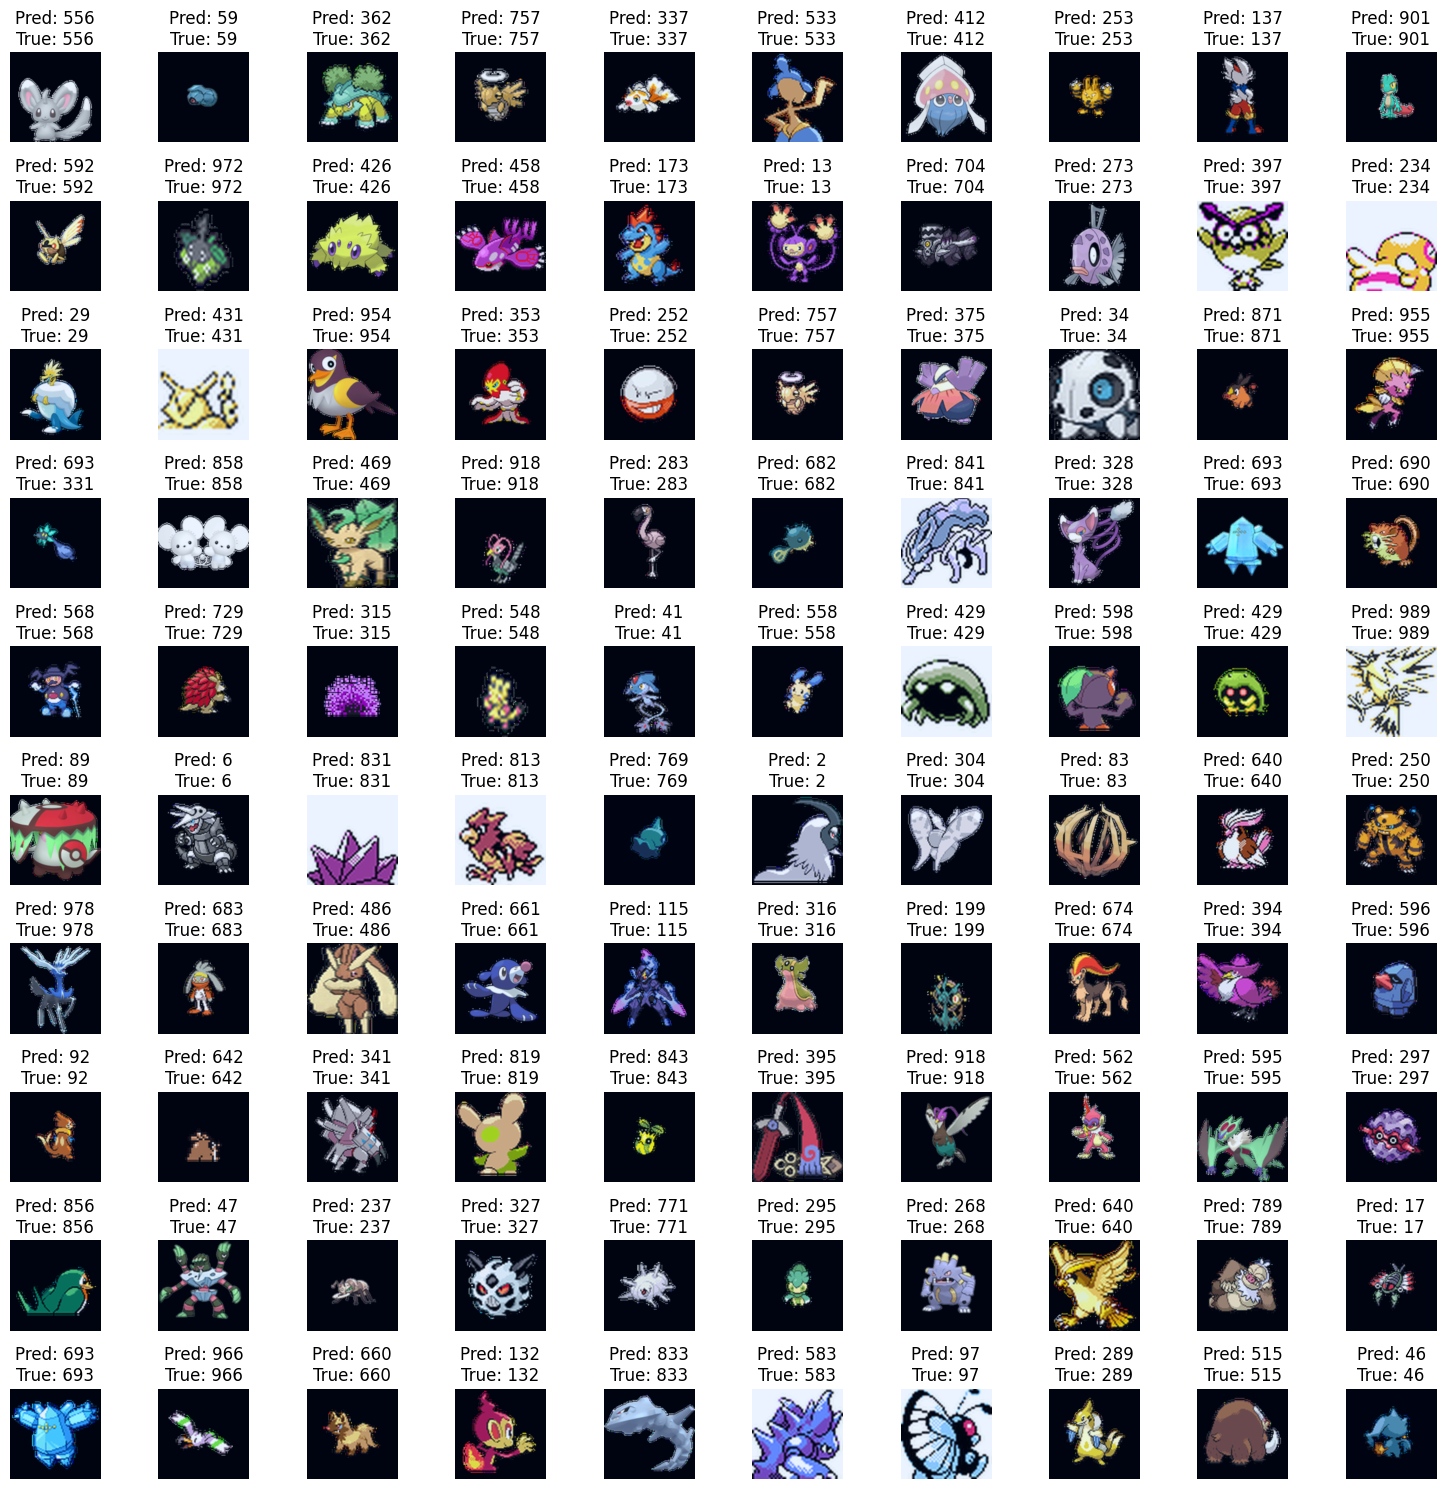

Accuracy: 99.00%


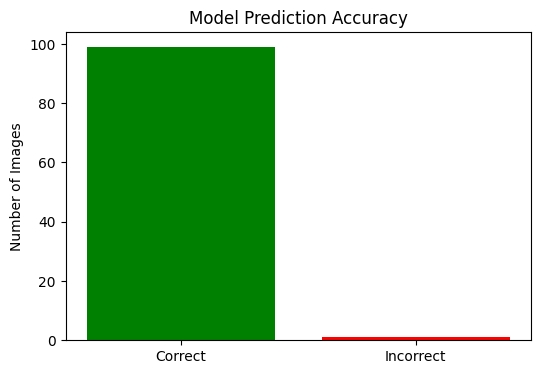

In [3]:
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# 테스트 데이터셋 불러오기
test_dataset = datasets.ImageFolder(root='pokemon-dataset-1000/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 랜덤 샘플 100개 추출
num_samples = 100
random_indices = random.sample(range(len(test_loader.dataset)), num_samples)

# 테스트 데이터셋에서 랜덤 샘플 가져오기
images, labels = [], []
for idx in random_indices:
    img, lbl = test_loader.dataset[idx]
    images.append(img)
    labels.append(lbl)

# 이미지를 모델 입력 형식으로 변환
images_tensor = torch.stack(images).to(device)
labels_tensor = torch.tensor(labels).to(device)

# 모델 예측
model.eval()
with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)

# 결과 시각화 (10x10 그리드로 출력)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.ravel()

# 정확도 계산용 변수
correct_count = 0

for i in range(num_samples):
    # 이미지를 [0, 1] 범위로 변환
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    # 시각화
    axes[i].imshow(img)
    pred_label = predicted[i].item()
    true_label = labels[i]
    
    # 정확도 계산
    if pred_label == true_label:
        correct_count += 1  # 맞춘 경우 카운트 증가
    
    axes[i].set_title(f"Pred: {pred_label}\nTrue: {true_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 정확도 계산 및 출력
accuracy = correct_count / num_samples * 100
print(f"Accuracy: {accuracy:.2f}%")

# 바 차트로 정확도 표현
plt.figure(figsize=(6, 4))
plt.bar(["Correct", "Incorrect"], [correct_count, num_samples - correct_count], color=["green", "red"])
plt.title("Model Prediction Accuracy")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

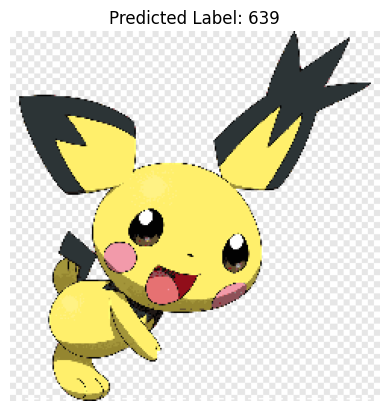

Predicted Label Index: 639
Predicted Label Name: pichu


In [7]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms

# 이미지 경로
# image_path = r"Sample_Image/pokemon_resized_244x244.jpg" # 배경 없는 사진
# image_path = r"Sample_Image/resized_molters_image_244x244.jpg" # 배경 있는 사진
# image_path = r"Sample_Image/resized_pikachu_image_244x244.jpg" # 비슷한 사진 1
image_path = r"Sample_Image/resized_pichu_image_244x244.png" # 비슷한 사진 2

# 모델 입력에 맞는 전처리 파이프라인
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 로드 및 전처리
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가

# 모델 예측
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1)

# 결과 시각화
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label.item()}")
plt.axis('off')
plt.show()

# 고유 라벨 이름과 번호 매핑
label_to_index = {label: idx for idx, label in enumerate(metadata['label'].unique())}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 모델의 예측 결과를 라벨 이름으로 변환하는 함수
def get_label_name(label_index):
    return index_to_label.get(label_index, "Unknown Label")

# 테스트: 모델 예측 결과 예시
predicted_label_index = predicted_label.item()  # 모델 예측값
predicted_label_name = get_label_name(predicted_label_index)

print(f"Predicted Label Index: {predicted_label_index}")
print(f"Predicted Label Name: {predicted_label_name}")
